In [1]:
from functools import partial
import os
import pickle
import random
import sys
sys.path.append(f'{os.getcwd()}/../')
print(sys.path)

from lib.models.model_execution_support import fit_linear_predictor
from lib.models.model_execution_support import train_and_forecast
from lib.models.recurrent_sigmoid_piecewise_forecaster import StackedRCellsForecaster
from lib.models.recurrent_sigmoid_piecewise_forecaster import GRUForecaster
from lib.models.recurrent_sigmoid_piecewise_forecaster import LSTMForecaster
from lib.models.linear_forecaster import LinearForecaster
from lib.utils.recurrent_contexts_manager import RecurrentContextsManager

import numpy as np
import pandas as pd
import torch

['/home/dude/micromamba/envs/ml_env/lib/python310.zip', '/home/dude/micromamba/envs/ml_env/lib/python3.10', '/home/dude/micromamba/envs/ml_env/lib/python3.10/lib-dynload', '', '/home/dude/micromamba/envs/ml_env/lib/python3.10/site-packages', '/home/dude/my_projects/nau_forecasting/notebooks/../']


In [2]:
def seed_everything(seed: int):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
seed_everything(42)

In [3]:
df = pd.read_csv('~/m5-dataset/M5-dataset/Dataset/sales_train_validation.csv')
test_df = pd.read_csv('~/m5-dataset/M5-dataset/Dataset/sales_test_validation.csv')

In [4]:
print(len(df.columns))
print(df.shape)
raw_vals = df.values
print(type(raw_vals), raw_vals.shape)

1918
(30490, 1918)
<class 'numpy.ndarray'> (30490, 1918)


In [5]:
products = df.item_id.unique()
depts = df.dept_id.unique()
categories = df.cat_id.unique()
stores = df.store_id.unique()
states = df.state_id.unique()
print(categories)
print(depts)
print(len(products))
print(states)
print(len(stores))

['HOBBIES' 'HOUSEHOLD' 'FOODS']
['HOBBIES_1' 'HOBBIES_2' 'HOUSEHOLD_1' 'HOUSEHOLD_2' 'FOODS_1' 'FOODS_2'
 'FOODS_3']
3049
['CA' 'TX' 'WI']
10


In [6]:
prod_0_sales = df[df.item_id == products[0]].values
prod_0_sales = prod_0_sales[:, 5:].mean(axis=0)
print(prod_0_sales.shape)

(1913,)


In [7]:
timeseries = []
test_timeseries = []
keys = []
for cat in categories:
    for store in stores:
        agg_ts = df[(df.store_id == store) & (df.cat_id == cat)].values[:, 5:].mean(axis=0)
        timeseries.append(agg_ts.astype(np.float32))
        keys.append((cat, store))
        agg_test_ts = test_df[(test_df.store_id == store) & (test_df.cat_id == cat)].values[:, 5:].mean(axis=0)
        test_timeseries.append(agg_test_ts.astype(np.float32))

In [8]:
print(len(timeseries))
print(timeseries[10][:10])

30
[0.51766956 0.4966571  0.37535816 0.38299903 0.31518623 0.38395417
 0.39255014 0.6743075  0.4680038  0.31232092]


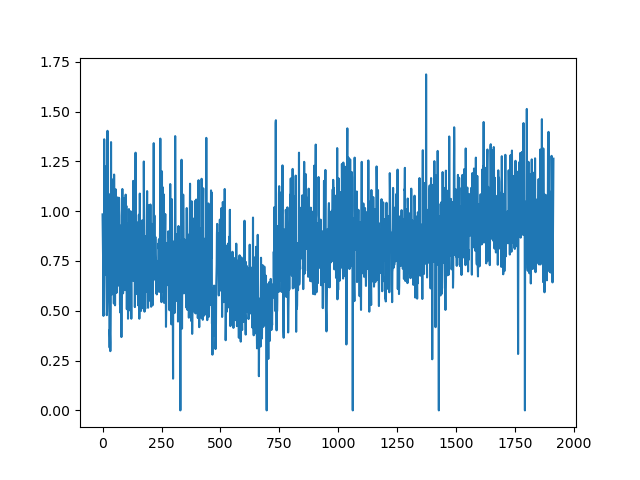

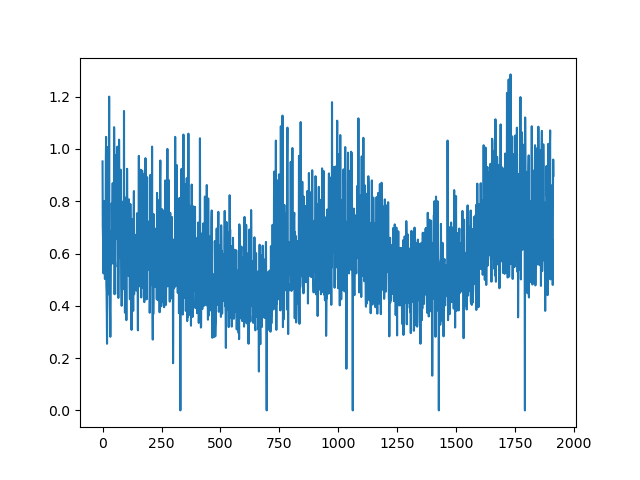

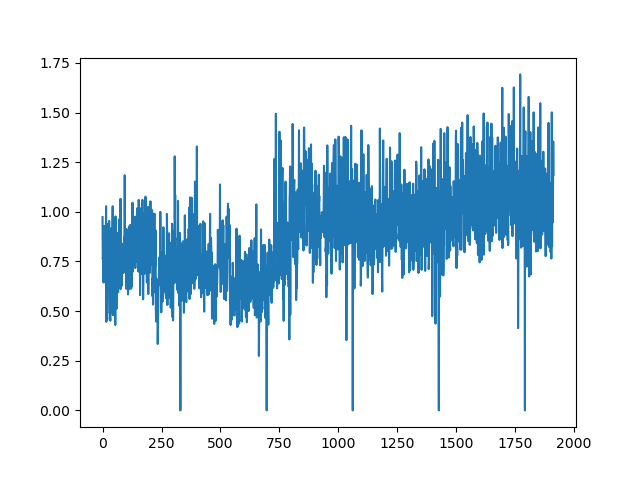

In [9]:
%matplotlib widget
from matplotlib import pyplot as plt
for i in range(3):
    plt.figure()
    plt.plot(range(len(timeseries[i])), timeseries[i])

In [10]:
######################################################################################

In [11]:
EXPERIMENTS_ROOT_DIR = '../experiments'
os.makedirs(EXPERIMENTS_ROOT_DIR, exist_ok=True)
timeseries_dir = os.path.join(EXPERIMENTS_ROOT_DIR, 'time_series')
linear_baselines_dir = os.path.join(EXPERIMENTS_ROOT_DIR, 'linear_baselines')
recurrent_models_dir = os.path.join(EXPERIMENTS_ROOT_DIR, 'models_experiments')
ALL_MODELS = [
    'RSP_normed',
    'RSP',
    'GRU_normed',
    'GRU',    
    'LSTM_normed',
    'LSTM',
]
ALL_MODELS_EXT = ALL_MODELS + ['linear']
CONFIGURATIONS = [
    {
        'input_size': 2,
        'hidden_size': 4,
        'layers_num': 1
    },
    {
        'input_size': 4,
        'hidden_size': 8,
        'layers_num': 3
    }
]

os.makedirs(timeseries_dir, exist_ok=True)
os.makedirs(linear_baselines_dir, exist_ok=True)
os.makedirs(recurrent_models_dir, exist_ok=True)


def get_ts_fname(ts_idx):
    return f'{timeseries_dir}/ts_{ts_idx}.npy'


def get_test_ts_fname(ts_idx):
    return f'{timeseries_dir}/test_ts_{ts_idx}.npy'


def get_linear_baseline_results_fname(ts_idx, inp_size):
    return f'{linear_baselines_dir}/lin_baseline_ts_{ts_idx}_is_{inp_size}.pt'

In [12]:
# for ts_idx in range(len(timeseries)):
#     ts, test_ts = timeseries[ts_idx], test_timeseries[ts_idx]
#     np.save(get_ts_fname(ts_idx), ts)
#     np.save(get_test_ts_fname(ts_idx), test_ts)


# for inp_size in (2, 4):
#     for ts_idx in range(len(timeseries)):
#         ts_fname, test_ts_fname = get_ts_fname(ts_idx), get_test_ts_fname(ts_idx)
#         results_fname = get_linear_baseline_results_fname(ts_idx, inp_size)
#         os.system(f'PYTHONPATH={os.getcwd()}/../ python ../scripts/train_linear_baseline.py -t {ts_fname} -T {test_ts_fname} -i {inp_size} -r {results_fname}')

In [13]:
ALL_ATTEMTS_SEEDS = range(42, 62)


def get_cfg_as_tuple(cfg):
    return cfg['input_size'], cfg['hidden_size'], cfg['layers_num']


def get_model_experiment_results_fname(cfg, ts_idx, neuron_type, seed):
    ins, hs, ln = cfg['input_size'], cfg['hidden_size'], cfg['layers_num']
    return f'{recurrent_models_dir}/exp_ts_{ts_idx}_nt_{neuron_type}_ins_{ins}_hs_{hs}_ln_{ln}_s_{seed}/results.pt'

In [14]:
ALL_MODEL_EXP_RESULTS = {}

for ts_idx in range(len(timeseries)):
    for neuron_type in ALL_MODELS:
        for cfg in CONFIGURATIONS:
            for attempt_seed in ALL_ATTEMTS_SEEDS:
                params = get_cfg_as_tuple(cfg) + (ts_idx, neuron_type, attempt_seed)
                exp_results_fname = get_model_experiment_results_fname(cfg, ts_idx, neuron_type, attempt_seed)
                os.makedirs(os.path.dirname(os.path.abspath(exp_results_fname)), exist_ok=True)
                ALL_MODEL_EXP_RESULTS[exp_results_fname] = params

In [15]:
import copy
model_exp_results_to_run = copy.deepcopy(ALL_MODEL_EXP_RESULTS)
finished_exp_results = set([f'{recurrent_models_dir}/{exp}/results.pt' for exp in os.listdir(recurrent_models_dir)])
finished_exp_results = [f for f in finished_exp_results if os.path.exists(f)]
print(len(finished_exp_results))

7200


In [16]:
for finished_exp in finished_exp_results:
    del model_exp_results_to_run[finished_exp]

print(len(model_exp_results_to_run))

0


In [17]:
print(os.cpu_count())

24


In [18]:
import time
from subprocess import Popen
import shlex


SLEEP_BETWEEN_POLLS = 60
MAX_WORKER_PROCESSES = os.cpu_count()

running_processes = {}

failed_exps = []
num_finished_exps = 0

start = time.time()

os.environ['PYTHONPATH'] = f'{os.getcwd()}/../'

while len(model_exp_results_to_run) > 0 or len(running_processes) > 0:
    finished_pids = []
    for pid, (proc, exp_result_fname) in running_processes.items():
        proc.poll()
        if proc.returncode is not None:
            if proc.returncode != 0:
                failed_exps.append(exp_result_fname)
            else:
                print(f'Finished exp: {exp_result_fname}')
                num_finished_exps += 1
                dur = int(time.time() - start)
                print(f'Finished {num_finished_exps} in {dur // 60} minutes, approx. {dur // 60 / num_finished_exps} minutes per experiment.')
            finished_pids.append(pid)
    for pid in finished_pids:
        del running_processes[pid]
    while len(running_processes) < MAX_WORKER_PROCESSES and len(model_exp_results_to_run) > 0:
        exp_result_fname, exp_params = model_exp_results_to_run.popitem()
        ins, hs, ln, ts_idx, nt, s = exp_params
        lin_fname = get_linear_baseline_results_fname(ts_idx, ins)
        lin_fname = os.path.abspath(lin_fname)
        cmd = f'python ../scripts/train_recurrent_model.py -b {lin_fname} -n {nt} -i {ins} -H {hs} -l {ln} -s {s} -r {os.path.abspath(exp_result_fname)}'
        proc = Popen(shlex.split(cmd))
        running_processes[proc.pid] = (proc, exp_result_fname)
    time.sleep(SLEEP_BETWEEN_POLLS)

print(f'DONE!!! Number of failed experiments: {len(failed_exps)}')

DONE!!! Number of failed experiments: 0


In [19]:
from collections import defaultdict


def rmsse(gt, pred, train_ts, h=28):
    n = train_ts.shape[0]
    denom = (h / (n - 1)) * np.square(train_ts[1:] - train_ts[:-1]).sum()
    nom = np.square(gt - pred).sum()
    return np.sqrt(nom / denom)


errs = defaultdict(dict)
val_errs = defaultdict(dict)
lin_errs = defaultdict(list)

for cfg in CONFIGURATIONS:
    ins = cfg['input_size']
    lin_errs_for_ins = lin_errs[ins]
    for ts_idx in range(len(timeseries)):
        lin_fname = get_linear_baseline_results_fname(ts_idx, ins)
        lin_results = torch.load(lin_fname, weights_only=False)
        lin_errs_for_ins.append(rmsse(lin_results['test_timeseries'], lin_results['linear_model_forecasts'], lin_results['timeseries']))

for neuron_type in ALL_MODELS_EXT:
    errs_per_neuron = errs[neuron_type]
    val_errs_per_neuron = val_errs[neuron_type]
    for ts_idx in range(len(timeseries)):
        errs_per_neuron.setdefault(ts_idx, {})
        val_errs_per_neuron.setdefault(ts_idx, {})
        for cfg in CONFIGURATIONS:
            cfg_params = get_cfg_as_tuple(cfg)
            errors_all_attempts = errs_per_neuron[ts_idx].setdefault(cfg_params, [])
            val_errors_all_attempts = val_errs_per_neuron[ts_idx].setdefault(cfg_params, [])
            for attempt_seed in ALL_ATTEMTS_SEEDS:
                if neuron_type != 'linear':
                    exp_results_fname = get_model_experiment_results_fname(cfg, ts_idx, neuron_type, attempt_seed)
                    results_dict = torch.load(exp_results_fname, weights_only=False)
                    errors_all_attempts.append(float(results_dict['test_error']))
                    val_errors_all_attempts.append(float(results_dict['val_loss']))
                else:
                    val_errors_all_attempts.append(lin_errs[cfg['input_size']][ts_idx])
                    errors_all_attempts.append(lin_errs[cfg['input_size']][ts_idx])
            errs[neuron_type][ts_idx][cfg_params] = np.array(errors_all_attempts)
            val_errs[neuron_type][ts_idx][cfg_params] = np.array(val_errors_all_attempts)

In [20]:
errs_by_neuron = defaultdict(list)
filtered_errs_by_neuron = defaultdict(list)
NUM_TOP_VAL_ERRS_TO_FILTER = 4

for neuron_type in ALL_MODELS_EXT:
    for cfg in CONFIGURATIONS:
        cfg_params = get_cfg_as_tuple(cfg)
        key = cfg_params + (neuron_type,)
        for ts_idx in range(len(timeseries)):
            all_attempts_errs = errs[neuron_type][ts_idx][cfg_params]
            errs_by_neuron[key].extend(all_attempts_errs)
            val_sort_inds = np.argsort(val_errs[neuron_type][ts_idx][cfg_params])
            filtered_errs_by_neuron[key].extend(all_attempts_errs[val_sort_inds][:-NUM_TOP_VAL_ERRS_TO_FILTER])
        errs_by_neuron[key] = np.array(errs_by_neuron[key])
        filtered_errs_by_neuron[key] = np.array(filtered_errs_by_neuron[key])

In [21]:
for cfg in CONFIGURATIONS:
    print(f'CONFIG: {get_cfg_as_tuple(cfg)}')
    for neuron_type in ALL_MODELS_EXT:
        print(f'    NEURON TYPE: {neuron_type}')
        key = get_cfg_as_tuple(cfg) + (neuron_type,)
        print(f'        Median err: {np.median(errs_by_neuron[key])}')
        print(f'        Err std: {np.std(errs_by_neuron[key])}')
        print(f'        Median filtered err: {np.median(filtered_errs_by_neuron[key])}')
        print(f'        Mean filtered err: {np.mean(filtered_errs_by_neuron[key])}')
        print(f'        Filtered err std: {np.std(filtered_errs_by_neuron[key])}')

CONFIG: (2, 4, 1)
    NEURON TYPE: RSP_normed
        Median err: 1.1161788430017467
        Err std: 11.23980149486034
        Median filtered err: 1.0857254272833643
        Mean filtered err: 1.220904998368027
        Filtered err std: 0.4927563062070291
    NEURON TYPE: RSP
        Median err: 1.1029577597259983
        Err std: 5.595412401936379
        Median filtered err: 1.074212064286094
        Mean filtered err: 1.186120978228604
        Filtered err std: 0.41973214780748025
    NEURON TYPE: GRU_normed
        Median err: 1.1405189841354826
        Err std: 916.6327191679907
        Median filtered err: 1.0914262635261103
        Mean filtered err: 1.2328945004624983
        Filtered err std: 0.5508089189178101
    NEURON TYPE: GRU
        Median err: 1.1672896962844108
        Err std: 49449.87018992469
        Median filtered err: 1.1371210593002155
        Mean filtered err: 1.2776779505591052
        Filtered err std: 0.6367561997297895
    NEURON TYPE: LSTM_normed
     

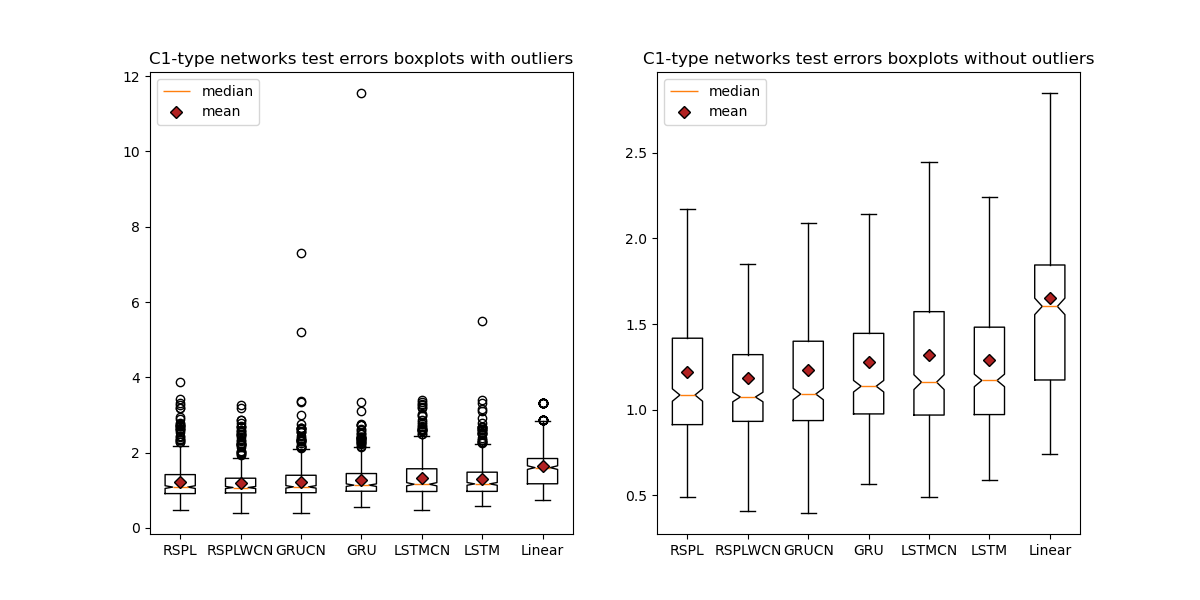

In [22]:
meanprops = dict(marker='D', markeredgecolor='black', markerfacecolor='firebrick')
tick_labels = ['RSPL', 'RSPLWCN', 'GRUCN', 'GRU', 'LSTMCN', 'LSTM', 'Linear']
errs_c1 = []
for neuron_type in ALL_MODELS_EXT:
    key = get_cfg_as_tuple(CONFIGURATIONS[0]) + (neuron_type,)
    errs_c1.append(filtered_errs_by_neuron[key])
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=False)
bp0 = ax[0].boxplot(errs_c1, showfliers=True, tick_labels=tick_labels, showmeans=True, notch=True, meanprops=meanprops)
ax[0].set_title('C1-type networks test errors boxplots with outliers')
ax[0].legend([bp0['medians'][0], bp0['means'][0]], ['median', 'mean'], loc='upper left')
bp1 = ax[1].boxplot(errs_c1, showfliers=False, tick_labels=tick_labels, showmeans=True, notch=True, meanprops=meanprops)
ax[1].set_title('C1-type networks test errors boxplots without outliers')
ax[1].legend([bp1['medians'][0], bp1['means'][0]], ['median', 'mean'], loc='upper left')
plt.show()

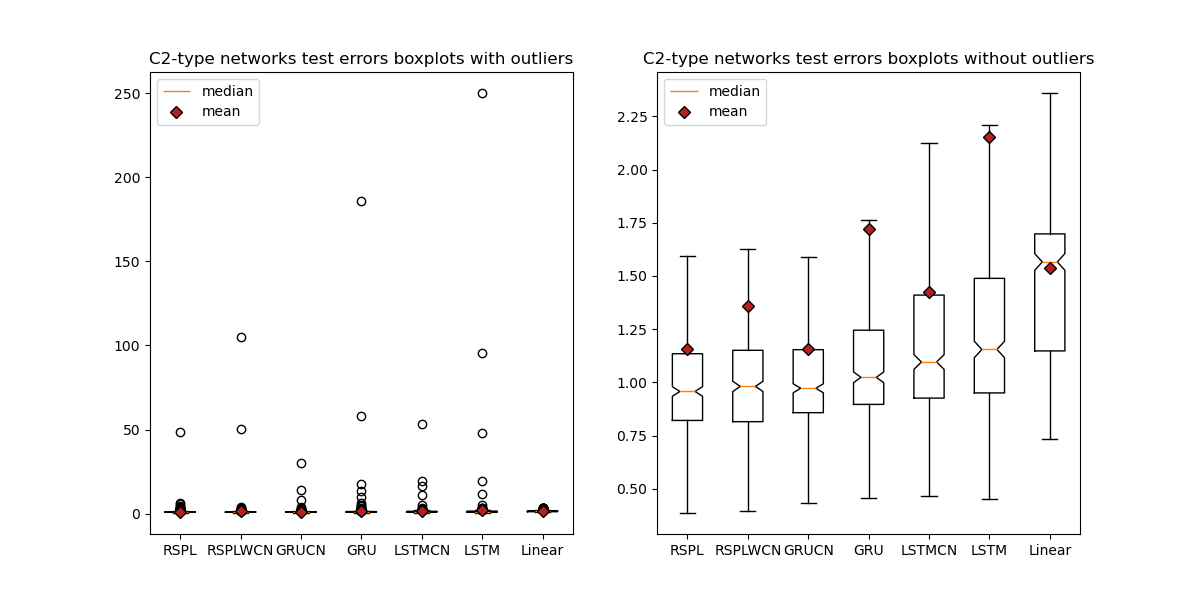

In [23]:
errs_c2 = []
for neuron_type in ALL_MODELS_EXT:
    key = get_cfg_as_tuple(CONFIGURATIONS[1]) + (neuron_type,)
    errs_c2.append(filtered_errs_by_neuron[key])
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=False)
bp0 = ax[0].boxplot(errs_c2, showfliers=True, tick_labels=tick_labels, showmeans=True, notch=True, meanprops=meanprops)
ax[0].set_title('C2-type networks test errors boxplots with outliers')
ax[0].legend([bp0['medians'][0], bp0['means'][0]], ['median', 'mean'], loc='upper left')
bp1 = ax[1].boxplot(errs_c2, showfliers=False, tick_labels=tick_labels, showmeans=True, notch=True, meanprops=meanprops)
ax[1].set_title('C2-type networks test errors boxplots without outliers')
ax[1].legend([bp1['medians'][0], bp1['means'][0]], ['median', 'mean'], loc='upper left')
plt.show()

In [24]:
best_errs_by_neuron_and_num_attempts = defaultdict(list)

for neuron_type in ALL_MODELS_EXT:
    for ts_idx in range(len(timeseries)):
        for cfg in CONFIGURATIONS:
            cfg_params = get_cfg_as_tuple(cfg)
            for num_attempts in range(1, len(ALL_ATTEMTS_SEEDS) + 1):
                val_errs = errs[neuron_type][ts_idx][cfg_params][:num_attempts]
                best_err_idx = np.argmin(val_errs)
                best_errs_by_neuron_and_num_attempts[cfg_params + (neuron_type, num_attempts)].append(errs[neuron_type][ts_idx][cfg_params][best_err_idx])

In [25]:
print(len(best_errs_by_neuron_and_num_attempts[get_cfg_as_tuple(CONFIGURATIONS[0]) + ('RSP_normed', 1)]))

30


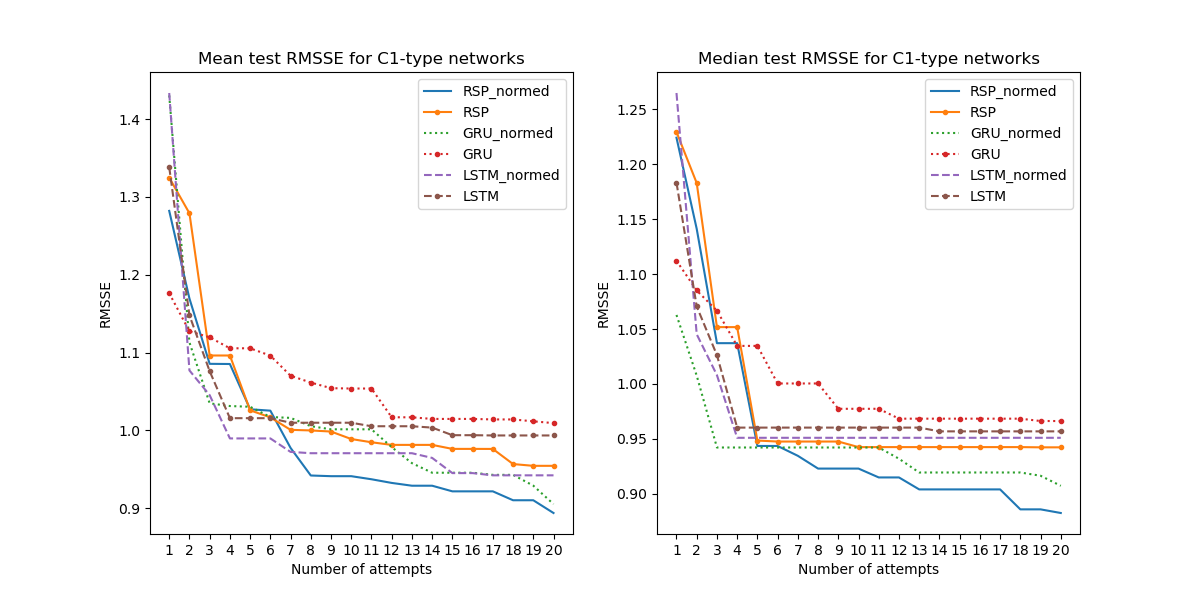

In [26]:
LINESTYLES_MAP = {
    'RSP': 'solid',
    'RSP_normed': 'solid',
    'GRU': 'dotted',
    'GRU_normed': 'dotted',
    'LSTM': 'dashed',
    'LSTM_normed': 'dashed',
}

x_range = range(1, len(ALL_ATTEMTS_SEEDS) + 1)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=False)
for nt in ALL_MODELS:
    marker = '.'
    if 'normed' in nt:
        marker = ''
    ax[0].plot(x_range, [np.mean(best_errs_by_neuron_and_num_attempts[get_cfg_as_tuple(CONFIGURATIONS[0]) + (nt, i)]) for i in x_range], label=nt, linestyle=LINESTYLES_MAP[nt], marker=marker)
for nt in ALL_MODELS:
    marker = '.'
    if 'normed' in nt:
        marker = ''
    ax[1].plot(x_range, [np.median(best_errs_by_neuron_and_num_attempts[get_cfg_as_tuple(CONFIGURATIONS[0]) + (nt, i)]) for i in x_range], label=nt, linestyle=LINESTYLES_MAP[nt], marker=marker)
ax[0].set_xticks(x_range, x_range)
ax[1].set_xticks(x_range, x_range)
ax[0].set_xlabel('Number of attempts')
ax[1].set_xlabel('Number of attempts')
ax[0].set_ylabel('RMSSE')
ax[1].set_ylabel('RMSSE')
ax[0].legend(loc='upper right')
ax[1].legend(loc='upper right')
ax[0].set_title('Mean test RMSSE for C1-type networks')
ax[1].set_title('Median test RMSSE for C1-type networks')
plt.show()

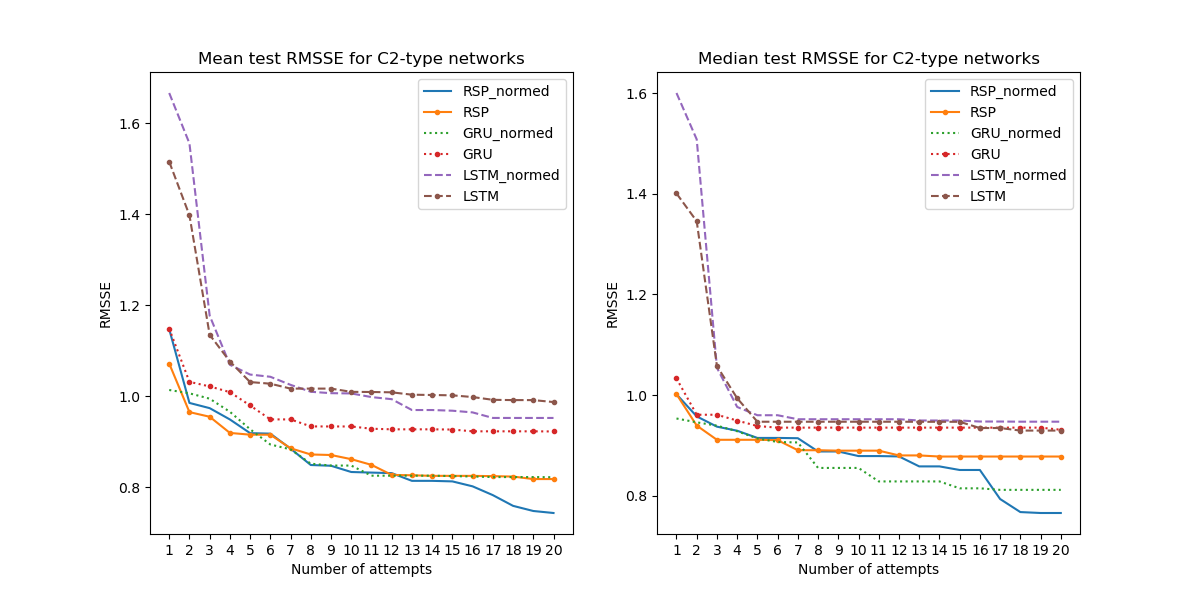

In [27]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=False)
for nt in ALL_MODELS:
    marker = '.'
    if 'normed' in nt:
        marker = ''
    ax[0].plot(x_range[:], [np.mean(best_errs_by_neuron_and_num_attempts[get_cfg_as_tuple(CONFIGURATIONS[1]) + (nt, i)]) for i in x_range[:]], label=nt, linestyle=LINESTYLES_MAP[nt], marker=marker)
for nt in ALL_MODELS:
    marker = '.'
    if 'normed' in nt:
        marker = ''
    ax[1].plot(x_range, [np.median(best_errs_by_neuron_and_num_attempts[get_cfg_as_tuple(CONFIGURATIONS[1]) + (nt, i)]) for i in x_range], label=nt, linestyle=LINESTYLES_MAP[nt], marker=marker)
ax[0].set_xticks(x_range, x_range)
ax[1].set_xticks(x_range, x_range)
ax[0].set_xlabel('Number of attempts')
ax[1].set_xlabel('Number of attempts')
ax[0].set_ylabel('RMSSE')
ax[1].set_ylabel('RMSSE')
ax[0].legend(loc='upper right')
ax[1].legend(loc='upper right')
ax[0].set_title('Mean test RMSSE for C2-type networks')
ax[1].set_title('Median test RMSSE for C2-type networks')
plt.show()

In [28]:
for cfg in CONFIGURATIONS:
    cfg_params = get_cfg_as_tuple(cfg)
    print(f'CFG: {cfg_params}')
    for neuron_type in ALL_MODELS_EXT:
        neuron_cfg_best_errs = np.array(best_errs_by_neuron_and_num_attempts[cfg_params + (neuron_type, len(ALL_ATTEMTS_SEEDS))])
        print(f'Neuron: {neuron_type}, mean: {np.mean(neuron_cfg_best_errs)}, median: {np.median(neuron_cfg_best_errs)}, std: {np.std(neuron_cfg_best_errs)}')

CFG: (2, 4, 1)
Neuron: RSP_normed, mean: 0.893800352099127, median: 0.8826020107736791, std: 0.2668301440778282
Neuron: RSP, mean: 0.9544325599363801, median: 0.942355828608753, std: 0.24650919190062565
Neuron: GRU_normed, mean: 0.9052342160234065, median: 0.9073595609723663, std: 0.29034570629803397
Neuron: GRU, mean: 1.0093308638738867, median: 0.9663040565083831, std: 0.29728434731875564
Neuron: LSTM_normed, mean: 0.9422156268591011, median: 0.9510389600970707, std: 0.29365814244548377
Neuron: LSTM, mean: 0.9934635926117839, median: 0.956897574151276, std: 0.2531656531006269
Neuron: linear, mean: 1.6491258246718035, median: 1.6029319434847482, std: 0.5937389927029566
CFG: (4, 8, 3)
Neuron: RSP_normed, mean: 0.7430627176882113, median: 0.7659890603042914, std: 0.2085720056703394
Neuron: RSP, mean: 0.817707429053587, median: 0.8781408428306251, std: 0.24027175566773673
Neuron: GRU_normed, mean: 0.8217235354225294, median: 0.8119498870200343, std: 0.20302275196731587
Neuron: GRU, mean: